# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. The MADDPG Solution

See the commented file `multi_ddpg.py` and `model.py` for more details. Essentially is implemented the same algorithm of the original [MADDPG paper](https://arxiv.org/pdf/1706.02275.pdf).


In [5]:
# Import files
from multi_ddpg import Agent
import torch
from collections import OrderedDict, namedtuple, deque
import matplotlib.pyplot as plt

In [6]:
# Instance of the multi ddpg agents (in this context 2 agents are instanciated )
agent = Agent(state_size, action_size, random_seed=2)

### Training loop
def run_ddpg_multi(n_episodes=5000, queue=100):        
    """Multi Deep Deterministic Policy Gradient learning for Tennis Unity Environment.
    
    Params Input
    ==========
        n_episode (int): maximum number of episodes
        queue (int): number of consecutive episodes to average up
        
    Params Output
    ==========
        scores_all (list of floats): are the scores collected at the end of each episode
        
    """
    
    ##Inizialization
    scores_window = deque(maxlen=queue)     
    scores_all = []                         
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(2)
        
        ## Training loop of each episode
        while True:
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            scores += rewards                                  
            states = next_states                               
            if np.any(dones):                                  
                break

        scores_window.append(np.max(scores))
        scores_all.append(np.max(scores))
        
        print('Episode {} ## Reward 1 agent: {:.3f} ##  Reward 2 : {:.3f} ## Max: {:.3f}'.format(
                i_episode, scores[0], scores[1], np.max(scores)))
        print('Average Score of last 100 episodes: {:.3f}'.format(np.mean(scores_window) ))

        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
                i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local0.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agent.critic_local0.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agent.actor_local1.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent.critic_local1.state_dict(), 'checkpoint_critic1.pth')
            break

    return scores_all

### 5. Run and plot of the outcome

Episode 1 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 2 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 3 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 4 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 5 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 6 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 7 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 8 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.000
Episode 9 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100

Episode 73 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 74 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 75 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 76 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 77 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 78 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 79 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 80 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 81 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of

Episode 145 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.003
Episode 146 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.003
Episode 147 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.003
Episode 148 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.003
Episode 149 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.003
Episode 150 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.004
Episode 151 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.004
Episode 152 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.004
Episode 153 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average S

Episode 217 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 218 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 219 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 220 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 221 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 222 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 223 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 224 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.005
Episode 225 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average

Episode 289 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.011
Episode 290 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.011
Episode 291 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.011
Episode 292 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.011
Episode 293 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.011
Episode 294 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.011
Episode 295 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.012
Episode 296 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.013
Episode 297 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average

Episode 361 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Score of last 100 episodes: 0.025
Episode 362 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.026
Episode 363 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.026
Episode 364 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.027
Episode 365 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.027
Episode 366 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.027
Episode 367 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.027
Episode 368 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.027
Episode 369 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average S

Episode 433 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.036
Episode 434 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.036
Episode 435 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.036
Episode 436 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.036
Episode 437 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.035
Episode 438 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.035
Episode 439 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.034
Episode 440 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.035
Episode 441 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average

Episode 505 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.031
Episode 506 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.031
Episode 507 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.000 ## Max: 0.090
Average Score of last 100 episodes: 0.032
Episode 508 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.033
Episode 509 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.033
Episode 510 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.034
Episode 511 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.034
Episode 512 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.035
Episode 513 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Scor

Episode 577 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.054
Episode 578 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.055
Episode 579 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.056
Episode 580 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.056
Episode 581 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.056
Episode 582 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.055
Episode 583 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.055
Episode 584 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.056
Episode 585 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Sc

Episode 649 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.057
Episode 650 ## Reward 1 agent: -0.020 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.058
Episode 651 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.057
Episode 652 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.057
Episode 653 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.056
Episode 654 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.056
Episode 655 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.055
Episode 656 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.054
Episode 657 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average

Episode 721 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.052
Episode 722 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.052
Episode 723 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.052
Episode 724 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.052
Episode 725 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.052
Episode 726 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.052
Episode 727 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.052
Episode 728 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.053
Episode 729 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average 

Episode 793 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.080
Episode 794 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.079
Episode 795 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.078
Episode 796 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.079
Episode 797 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.079
Episode 798 ## Reward 1 agent: 0.300 ##  Reward 2 : 0.190 ## Max: 0.300
Average Score of last 100 episodes: 0.081
Episode 799 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.081
Episode 800 ## Reward 1 agent: 0.400 ##  Reward 2 : 0.390 ## Max: 0.400
Average Score of last 100 episodes: 0.084
Episode 801 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Sc

Episode 865 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.090
Episode 866 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.089
Episode 867 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.090
Episode 868 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.090
Episode 869 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.088
Episode 870 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.087
Episode 871 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.086
Episode 872 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.086
Episode 873 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Sc

Episode 937 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.107
Episode 938 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.107
Episode 939 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.107
Episode 940 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.108
Episode 941 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.108
Episode 942 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.109
Episode 943 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.110
Episode 944 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.110
Episode 945 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average S

Episode 1009 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.104
Episode 1010 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.200 ## Max: 0.200
Average Score of last 100 episodes: 0.105
Episode 1011 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.105
Episode 1012 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.105
Episode 1013 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Score of last 100 episodes: 0.106
Episode 1014 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.105
Episode 1015 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.106
Episode 1016 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.200 ## Max: 0.200
Average Score of last 100 episodes: 0.107
Episode 1017 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Aver

Episode 1080 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.108
Episode 1081 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.108
Episode 1082 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.108
Episode 1083 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.109
Episode 1084 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.200 ## Max: 0.200
Average Score of last 100 episodes: 0.110
Episode 1085 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.110
Episode 1086 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.110
Episode 1087 ## Reward 1 agent: 0.300 ##  Reward 2 : 0.290 ## Max: 0.300
Average Score of last 100 episodes: 0.112
Episode 1088 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Aver

Episode 1151 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.124
Episode 1152 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.122
Episode 1153 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.122
Episode 1154 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.122
Episode 1155 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.121
Episode 1156 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.120
Episode 1157 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.118
Episode 1158 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.117
Episode 1159 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100

Episode 1222 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.120
Episode 1223 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.121
Episode 1224 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.123
Episode 1225 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.124
Episode 1226 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.124
Episode 1227 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.123
Episode 1228 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.000 ## Max: 0.000
Average Score of last 100 episodes: 0.121
Episode 1229 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.122
Episode 1230 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Av

Episode 1293 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Score of last 100 episodes: 0.130
Episode 1294 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.131
Episode 1295 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.132
Episode 1296 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.131
Episode 1297 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.131
Episode 1298 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.132
Episode 1299 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.132
Episode 1300 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.131
Episode 1301 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
A

Episode 1364 ## Reward 1 agent: 0.400 ##  Reward 2 : 0.390 ## Max: 0.400
Average Score of last 100 episodes: 0.153
Episode 1365 ## Reward 1 agent: 0.400 ##  Reward 2 : 0.390 ## Max: 0.400
Average Score of last 100 episodes: 0.155
Episode 1366 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.154
Episode 1367 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.155
Episode 1368 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.154
Episode 1369 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.154
Episode 1370 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.080 ## Max: 0.100
Average Score of last 100 episodes: 0.154
Episode 1371 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Score of last 100 episodes: 0.154
Episode 1372 ## Reward 1 agent: 0.300 ##  Reward 2 : 0.290 ## Max: 0.300
Avera

Episode 1435 ## Reward 1 agent: 0.000 ##  Reward 2 : 0.090 ## Max: 0.090
Average Score of last 100 episodes: 0.140
Episode 1436 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.139
Episode 1437 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.138
Episode 1438 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.138
Episode 1439 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.138
Episode 1440 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.138
Episode 1441 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.138
Episode 1442 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
Average Score of last 100 episodes: 0.134
Episode 1443 ## Reward 1 agent: 0.000 ##  Reward 2 : -0.010 ## Max: 0.000
A

Episode 1506 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.127
Episode 1507 ## Reward 1 agent: 0.300 ##  Reward 2 : 0.290 ## Max: 0.300
Average Score of last 100 episodes: 0.129
Episode 1508 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Score of last 100 episodes: 0.129
Episode 1509 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.128
Episode 1510 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.128
Episode 1511 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.129
Episode 1512 ## Reward 1 agent: 0.290 ##  Reward 2 : 0.400 ## Max: 0.400
Average Score of last 100 episodes: 0.132
Episode 1513 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.190 ## Max: 0.200
Average Score of last 100 episodes: 0.134
Episode 1514 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Aver

Episode 1577 ## Reward 1 agent: 0.400 ##  Reward 2 : 0.390 ## Max: 0.400
Average Score of last 100 episodes: 0.146
Episode 1578 ## Reward 1 agent: 0.100 ##  Reward 2 : 0.090 ## Max: 0.100
Average Score of last 100 episodes: 0.146
Episode 1579 ## Reward 1 agent: 0.200 ##  Reward 2 : 0.090 ## Max: 0.200
Average Score of last 100 episodes: 0.147
Episode 1580 ## Reward 1 agent: 0.190 ##  Reward 2 : 0.300 ## Max: 0.300
Average Score of last 100 episodes: 0.148
Episode 1581 ## Reward 1 agent: -0.010 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.148
Episode 1582 ## Reward 1 agent: 1.100 ##  Reward 2 : 1.090 ## Max: 1.100
Average Score of last 100 episodes: 0.158
Episode 1583 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.158
Episode 1584 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.156
Episode 1585 ## Reward 1 agent: 0.700 ##  Reward 2 : 0.590 ## Max: 0.700
Avera

Episode 1648 ## Reward 1 agent: 0.190 ##  Reward 2 : 0.300 ## Max: 0.300
Average Score of last 100 episodes: 0.179
Episode 1649 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.179
Episode 1650 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.177
Episode 1651 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.178
Episode 1652 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.200 ## Max: 0.200
Average Score of last 100 episodes: 0.180
Episode 1653 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.181
Episode 1654 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Average Score of last 100 episodes: 0.181
Episode 1655 ## Reward 1 agent: 0.090 ##  Reward 2 : 0.100 ## Max: 0.100
Average Score of last 100 episodes: 0.181
Episode 1656 ## Reward 1 agent: 0.100 ##  Reward 2 : -0.010 ## Max: 0.100
Ave

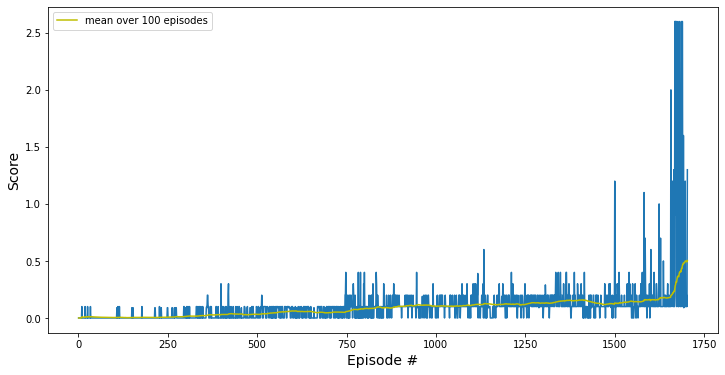

In [7]:
scores = run_ddpg_multi()

average_scores = []
temp_deque = deque(maxlen=100)
for s in scores:
    temp_deque.append(s)
    average_scores.append(np.mean(temp_deque))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(scores)+1), scores)
ax.plot(range(1, len(average_scores)+1), average_scores, c='y', label='mean over 100 episodes')
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
plt.legend()
plt.show()